<a href="https://colab.research.google.com/github/HrithikBT/Emotion_Analysis/blob/master/tess_cnn1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install -q pysoundfile

In [0]:
pip install -q librosa

In [0]:
pip install -q h5py

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import soundfile # to read audio file
import numpy as np
import librosa # to extract speech features
import glob
import os
import pickle # to save model after training
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score # to measure how good we are
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Activation, Dense,Conv1D,Dropout,MaxPooling1D,Flatten
from tensorflow import keras
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score
from keras.models import model_from_json

Using TensorFlow backend.


In [0]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result


In [0]:
# all emotions on TESS dataset
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy",
    "fear",
    "ps",
    "disgust"
}

In [0]:
def load_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("/content/drive/My Drive/TESS/*talker_*/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = (basename.split("_")[2]).split(".")[0]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract speech features
        features = extract_feature(file, mfcc=True, chroma=True, mel=True)
        # add to data
        X.append(features)
        y.append(emotion)
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [0]:
# load TESS dataset, 75% training 25% testing
X_train, X_test, y_train, y_test = load_data(test_size=0.25)
X_train, X_predict, y_train, y_predict = train_test_split(np.array(X_train), y_train, test_size=.20, random_state=7)
#'''
y_train = np.array(y_train)
#print(np.unique(y_train))
y_test = np.array(y_test)
y_predict = np.array(y_predict)

In [0]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
y_predict = np_utils.to_categorical(lb.fit_transform(y_predict))

In [0]:
print(y_train.shape)
print(y_test.shape)
print(y_predict.shape)

(1680, 7)
(700, 7)
(420, 7)


In [0]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])

[+] Number of training samples: 1680
[+] Number of testing samples: 700
[+] Number of features: 180


In [0]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
X_predict = np.expand_dims(X_predict,axis=2)

In [0]:
model = models.Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) #1
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same')) #2
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same')) #3
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same')) #4
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same')) #5
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same')) #6
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(7)) #7
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [0]:
# Fit Model
history = model.fit(np.array(x_traincnn), y_train, batch_size=16, epochs=100, validation_data=(np.array(x_testcnn), y_test))

Train on 1680 samples, validate on 700 samples
Epoch 1/100
1680/1680 [==============================] - 4s 3ms/sample - loss: 1.8510 - acc: 0.2881 - val_loss: 1.6340 - val_acc: 0.6729
Epoch 2/100
1680/1680 [==============================] - 1s 418us/sample - loss: 1.5019 - acc: 0.5542 - val_loss: 1.3769 - val_acc: 0.7171
Epoch 3/100
1680/1680 [==============================] - 1s 414us/sample - loss: 1.2349 - acc: 0.7000 - val_loss: 1.1136 - val_acc: 0.8186
Epoch 4/100
1680/1680 [==============================] - 1s 399us/sample - loss: 0.9899 - acc: 0.7863 - val_loss: 0.9027 - val_acc: 0.8629
Epoch 5/100
1680/1680 [==============================] - 1s 406us/sample - loss: 0.8068 - acc: 0.8292 - val_loss: 0.7372 - val_acc: 0.8686
Epoch 6/100
1680/1680 [==============================] - 1s 401us/sample - loss: 0.6634 - acc: 0.8589 - val_loss: 0.6113 - val_acc: 0.8686
Epoch 7/100
1680/1680 [==============================] - 1s 409us/sample - loss: 0.5510 - acc: 0.8762 - val_loss: 0.5108 

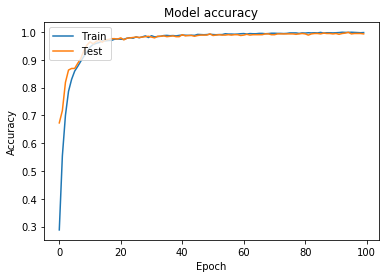

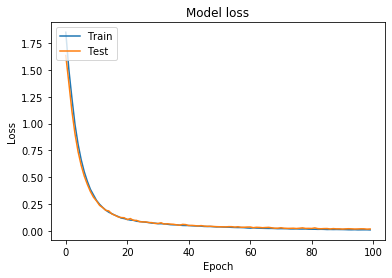

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
preds = model.predict(X_predict)

In [0]:
print(classification_report(np.argmax(y_predict,axis=1), np.argmax(preds,axis=1)))
# calculate the accuracy
accuracy = accuracy_score(y_true=np.argmax(y_predict,axis=1), y_pred=np.argmax(preds,axis=1))

print("Accuracy: {:.2f}%".format(accuracy*100))
# now we save the model
# make result directory if doesn't exist yet

#
#'''

In [0]:
model.save("/content/drive/My Drive/Saved_models/model.tess_cnn1d.h5")
print("Model saved")